In [2]:
%run "00_wall_of_imports.ipynb"

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key:")
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)
embeddings = OpenAIEmbeddings()

C:\Users\dabra\AppData\Local\Temp\ipykernel_23884\1492932338.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)


In [4]:
# Load the vector store
travel_db = FAISS.load_local("travel_db_faiss", embeddings, allow_dangerous_deserialization=True)

# Load the docstore
with open('travel_db_docstore.pkl', 'rb') as f:
    travel_db.docstore = pickle.load(f)

# Verify it loaded correctly
print(f"Loaded knowledge base with {len(travel_db.index_to_docstore_id)} documents")

2025-02-25 05:23:02 - Loading faiss with AVX512 support.
2025-02-25 05:23:02 - Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
2025-02-25 05:23:02 - Loading faiss with AVX2 support.


2025-02-25 05:23:02 - Successfully loaded faiss with AVX2 support.
2025-02-25 05:23:02 - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.
Loaded knowledge base with 4997 documents


In [5]:
## Step 2: Building the Multi-Agent System with LangGraph

# 1. **Router Agent**: Determines which specialized agent should handle the query
# 2. **Itinerary Agent**: Creates customized travel itineraries
# 3. **Flight Agent**: Handles flight-related questions and searches
# 4. **Accommodation Agent**: Provides hotel recommendations
# 5. **Information Agent**: Answers general travel questions using RAG

### 1. Define Agent States and Workflows
# Define the state for our agent system

# This class defines a state management system for a conversational AI agent, specifically designed for a travel assistant. 
# It uses Pydantic for data validation and LangChain for message handling. The state tracks various aspects 
# of the conversation including the user's query, conversation history, agent responses, and any errors that occur.

class AgentState(BaseModel):
    """State for the travel assistant workflow."""

    # Defines a class that inherits from BaseModel to manage agent state
    query: str                                                # Stores the user's input query as a string
    chat_history: List[Any] = Field(default_factory=list)     # Stores conversation history as a list, initialized as empty
    agent_executor: Optional[str] = None                      # Stores the name/type of agent executor being used, can be None
    agent_response: Optional[str] = None                      # Stores the agent's response, can be None
    final_response: Optional[str] = None                      # Stores the final processed response, can be None
    context: Dict[str, Any] = Field(default_factory=dict)     # Stores contextual information as a dictionary, initialized empty
    error: Optional[str] = None                               # Stores error messages if any occur, can be None
    messages: List[BaseMessage] = Field(default_factory=list) # Stores LangChain messages, initialized as empty list
    
    def __repr__(self):
         # Defines string representation of the AgentState object
        return f"AgentState(query={self.query}, agent_executor={self.agent_executor})"
        
    def to_dict(self):
        """Convert state to dictionary for LangGraph compatibility"""
        # Method to convert the state object to a dictionary
        return {
            "query": self.query,
            "chat_history": self.chat_history,
            "agent_executor": self.agent_executor,
            "agent_response": self.agent_response,
            "final_response": self.final_response,
            "context": self.context,
            "error": self.error,
            "messages": self.messages
        }    

In [6]:
def router_agent(state: AgentState) -> dict:
    """Router agent that determines which specialized agent should handle the query."""

    # Step 1: Creates a chat prompt template with system and human messages
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a travel assistant router. Your job is to determine which specialized agent
        should handle the user's travel-related query. Choose the most appropriate agent from:
        
        - itinerary_agent: For requests to create travel itineraries, vacation plans, or multi-day travel schedules
        - flight_agent: For questions about flights, airfares, airlines, or flight bookings
        - accommodation_agent: For questions about hotels, resorts, accommodations, or places to stay
        - information_agent: For general travel information, destination facts, or travel advice
        
        Respond ONLY with the name of the appropriate agent. Do not include any explanations or additional text.
        """),
        ("human", "{query}")
    ])
    
    # Step 2: Uses a chain to pass the user query to the LLM, get the recommended agent name and parse the output as a string
    chain = router_prompt | llm | StrOutputParser()

    agent_executor = chain.invoke({"query": state.query}).strip()
    
    valid_agents = ["itinerary_agent", "flight_agent", "accommodation_agent", "information_agent"]

    # Step 3: Validates the response: Checks if returned agent name is in valid_agents list, else defaults to "information_agent" if invalid
    if agent_executor not in valid_agents:
        # Default to information agent if invalid response
        agent_executor = "information_agent"
            
    # Step 4: Returns state as a dictionary
    return {"agent_executor": agent_executor, 
            "query": state.query,
            "chat_history": state.chat_history,
            "agent_response": state.agent_response,
            "final_response": state.final_response,
            "context": state.context,
            "error": state.error}

In [7]:
### 3. RAG Chain Setup - For Information Retrieval
def setup_rag_chain():
    """Set up the RAG chain for information retrieval."""
    # Create a retriever from our travel knowledge base by:
    # 1: using the FAISS vector database (travel_db)
    # 2: setting up a similarity search
    # 3: configuring it to return top 7 most relevant documents (k=7)
    retriever = travel_db.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 7}
    )
        
    rag_prompt = ChatPromptTemplate.from_template("""You are a knowledgeable travel assistant with expertise in destinations worldwide.
        Use the following travel information to provide detailed, accurate responses to the user's query.
        If the retrieved information doesn't fully answer the question, use your knowledge to provide
        the best possible response, but prioritize the retrieved information.
        
        Retrieved information: {context}        
        Question: {input}
    """)

    # Create the document processing chain by:
    # 1: creating a chain to process documents using the prompt and language model
    # 2: create_stuff_documents_chain method combines all documents into one context
    document_chain = create_stuff_documents_chain(llm, rag_prompt)
    
    return create_retrieval_chain(retriever, document_chain)

In [8]:
### 4. Specialized Agents Implementation
def itinerary_agent(state: AgentState) -> dict:
    """Creates customized travel itineraries based on user preferences."""
    try:
        # First, retrieve relevant destination information
        rag_chain = setup_rag_chain()
        retrieval_result = rag_chain.invoke({"input": state.query})
        
        # Extract destination information from query using LLM
        extraction_prompt = ChatPromptTemplate.from_template("""Extract the key travel information from the user's query.
        Return a JSON object with these fields (leave empty if not mentioned):
        {{
            "destinations": ["list of mentioned destinations"],
            "duration": "total trip duration in days",
            "budget": "budget information",
            "interests": ["list of mentioned interests/activities"],
            "travel_dates": "approximate travel dates",
            "travelers": "number and type of travelers (family, couple, solo, etc.)"
        }}
        
        Query: {input}
        """)       
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()

        try:
            # First check if the string is not empty
            if extraction_result := extraction_chain.invoke({"input": state.query}).strip():
                extracted_info = json.loads(extraction_result)
            else:
                extracted_info = {
                    "destinations": [],
                    "duration": "",
                    "budget": "",
                    "interests": [],
                    "travel_dates": "",
                    "travelers": ""
                }
            state.context.update(extracted_info)
        except json.JSONDecodeError:
            # Provide default structure when parsing fails
            extracted_info = {
                "destinations": [],
                "duration": "",
                "budget": "",
                "interests": [],
                "travel_dates": "",
                "travelers": ""
            }
            state.context.update(extracted_info)

        
        # Generate itinerary using retrieved information and extracted parameters
        itinerary_prompt = ChatPromptTemplate.from_template("""You are a travel itinerary expert. Create a detailed day-by-day travel itinerary
        based on the user's preferences and the retrieved destination information.
        
        For each day, include morning activities, lunch suggestions, afternoon activities, dinner recommendations, and 
        evening activities or relaxation options
        
        Also include practical advice about transportation between attractions, estimated costs, time management tips, and local customs.
        
        Make the itinerary realistic in terms of travel times and activities per day.
        
        Context information:
        {context_str}
        
        Extracted travel parameters:
        {parameters}
        
        Query: {input}
        """)        
        
        # Format the context and parameters for the prompt
        context_str = retrieval_result.get("answer", "")
        parameters_str = json.dumps(state.context, indent=2)
        
        itinerary_chain = itinerary_prompt | llm | StrOutputParser()
        response = itinerary_chain.invoke({
            "input": state.query,
            "context_str": context_str,
            "parameters": parameters_str
        })
        
        return {
            "agent_response": response,
            "context": state.context,
            "query": state.query
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "context": state.context,
            "query": state.query
        }

In [9]:
def flight_agent(state: AgentState) -> dict:
    """Handles flight-related questions and searches."""
    try:
        # Extract flight search parameters
        extraction_prompt = ChatPromptTemplate.from_template("""Extract flight search parameters from the user's query.
            Return a JSON object with these fields (leave empty if not mentioned):
        {{
            "origin": "origin airport or city code",
            "destination": "destination airport or city code",
            "departure_date": "departure date in YYYY-MM-DD format",
            "return_date": "return date in YYYY-MM-DD format (if round-trip)",
            "num_passengers": "number of passengers",
            "cabin_class": "economy/business/first",
            "price_range": "budget constraints",
            "airline_preferences": ["preferred airlines"]
        }}
        
        Query: {input}
        """)       
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()

        try:
            flight_params = json.loads(extraction_chain.invoke({"input": state.query}))  # Changed from input.query to state.query
            state.context.update({"flight_params": flight_params})
        except json.JSONDecodeError:
            state.context.update({"flight_params": {}})
        
        # Get flight information using RAG
        rag_chain = setup_rag_chain()
        retrieval_result = rag_chain.invoke({"input": state.query})

        flight_prompt = ChatPromptTemplate.from_template("""You are a flight search specialist. Provide helpful information about flights
            based on the retrieved flight data and the user's query. Include details about available flights matching the criteria, 
            price ranges and fare comparisons, airline options, departure/arrival times, travel duration, layovers (if applicable), 
            and booking recommendations.
            
            If exact flight information isn't available in the retrieved data, provide general advice
            about the requested route, typical prices, and best booking strategies.
            
            Retrieved flight information:
            {context_str}
            
            Extracted flight parameters:
            {parameters}
        
            Query: {input}
            """)
        
        # Format the context and parameters for the prompt
        context_str = retrieval_result.get("answer", "")
        parameters_str = json.dumps(state.context.get("flight_params", {}), indent=2)
        
        flight_chain = flight_prompt | llm | StrOutputParser()
        response = flight_chain.invoke({
            "input": state.query,
            "context_str": context_str,
            "parameters": parameters_str
        })
        
        return {
            "agent_response": response,
            "context": state.context,
            "query": state.query
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "context": state.context,
            "query": state.query
        }

In [10]:
def accommodation_agent(state: AgentState) -> dict:
    """Provides hotel and accommodation recommendations."""
    try:
        # Extract accommodation preferences
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """Extract accommodation preferences from the user's query.
            Return a JSON object with these fields (leave empty if not mentioned):
            {{
                "location": "city or specific area",
                "check_in_date": "in YYYY-MM-DD format",
                "check_out_date": "in YYYY-MM-DD format",
                "guests": "number of guests",
                "rooms": "number of rooms",
                "budget_range": "price range per night"
            }}
            """),  # Note the double curly braces
            ("human", "{query}")
        ])
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()
        try:
            accommodation_params = json.loads(extraction_chain.invoke({"query": state.query}))
            state.context.update({"accommodation_params": accommodation_params})
        except json.JSONDecodeError:
            state.context.update({"accommodation_params": {}})
        
        # Get accommodation information using RAG
        rag_chain = setup_rag_chain()
        retrieval_result = rag_chain.invoke({"query": f"hotels in {state.context.get('accommodation_params', {}).get('location', '')}"})
        
        # Generate response based on accommodation parameters and retrieved information
        accommodation_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a hotel and accommodation expert. Provide detailed recommendations
            based on the user's preferences and the retrieved accommodation data. Include:
            
            - Suitable hotel/accommodation options
            - Price ranges and value considerations
            - Location benefits and proximity to attractions
            - Amenities and facilities
            - Guest ratings and reviews summary
            - Booking tips and optimal timing
            
            If specific accommodation data isn't available, provide general advice about
            accommodations in the requested location, typical options at different price points,
            and best areas to stay.
            
            Retrieved accommodation information:
            {context}
            
            Extracted accommodation parameters:
            {accommodation_params}
            """),
            ("human", "{query}")
        ])
        
        accommodation_chain = accommodation_prompt | llm | StrOutputParser()
        response = accommodation_chain.invoke({
            "query": state.query,
            "context": retrieval_result.get("context", ""),
            "accommodation_params": json.dumps(state.context.get("accommodation_params", {}), indent=2)
        })
        
        return {"agent_response": response}
        
    except Exception as e:
        return {"error": str(e)}

In [11]:
def information_agent(state: AgentState) -> dict:
    """Answers general travel questions using RAG."""
    try:
        # This agent directly uses the RAG chain to provide travel information
        rag_chain = setup_rag_chain()
        result = rag_chain.invoke({"input": state.query})  # Changed from query to input
        
        # Enhance RAG response with additional context if needed
        enhancement_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a knowledgeable travel information specialist. Review and enhance
            the retrieved information to provide a comprehensive, accurate response to the user's query.
            
            If the retrieved information is incomplete, add relevant details from your knowledge while
            clearly distinguishing between retrieved facts and general knowledge.
            
            Focus on providing practical, useful information that directly addresses the user's needs.
            Include cultural insights, traveler tips, and seasonal considerations when relevant.
            
            Retrieved information:
            {rag_response}
            """),
            ("human", "{input}")  # Changed from query to input
        ])
        
        enhancement_chain = enhancement_prompt | llm | StrOutputParser()
        enhanced_response = enhancement_chain.invoke({
            "input": state.query,
            "rag_response": result.get("answer", "")
        })
        
        return {"agent_response": enhanced_response}
        
    except Exception as e:
        return {"error": str(e)}

In [12]:
### 5. Response Generator - Creates the final response
def generate_final_response(state: AgentState) -> dict:
    """Generates the final, polished response to the user."""
    # Create a consistent, helpful response format
    formatting_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly, helpful travel assistant. Format the specialized agent's response
        into a clear, well-structured, and engaging reply. Maintain all the factual information and advice
        while improving readability with:
        
        - A warm, conversational tone
        - Logical organization with headings where appropriate
        - Bullet points for lists
        - Bold text for important information
        - Emojis where appropriate (but not excessive)
        
        Make sure the response completely addresses the user's query. Add a brief, friendly closing
        that invites further questions.
        
        Original agent response:
        {agent_response}
        """),
        ("human", "{query}")
    ])
    
    formatting_chain = formatting_prompt | llm | StrOutputParser()
    final_response = formatting_chain.invoke({
        "query": state.query,
        "agent_response": state.agent_response
    })
    
    # state.final_response = final_response
    # return state.to_dict()
    return {"agent_response": final_response}

In [13]:
### 6. Error Handler - Manages errors gracefully
def handle_error(state: AgentState) -> dict:
    """Handles errors and provides a graceful fallback response."""
    error_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful travel assistant. The system encountered an error while
        processing the user's query. Provide a helpful response that:
        
        1. Acknowledges the issue
        2. Offers general travel advice related to their query
        3. Suggests how they might rephrase their question for better results
        
        Error message: {error}
        """),
        ("human", "{query}")
    ])
    
    error_chain = error_prompt | llm | StrOutputParser()
    fallback_response = error_chain.invoke({
        "query": state.query,
        "error": state.error or "Unknown error occurred"
    })
    
    # state.final_response = fallback_response
    # return state.to_dict()
    return {"agent_response": fallback_response}

In [14]:
def create_travel_assistant_graph():
    """Creates the travel assistant graph using LangGraph."""
    # Initialize the workflow graph
    workflow = StateGraph(AgentState)
    
    # Add nodes for each agent and processing step
    workflow.add_node("router", router_agent)
    workflow.add_node("itinerary_agent", itinerary_agent)
    workflow.add_node("flight_agent", flight_agent)
    workflow.add_node("accommodation_agent", accommodation_agent)
    workflow.add_node("information_agent", information_agent)
    workflow.add_node("response_generator", generate_final_response)
    workflow.add_node("error_handler", handle_error)
    
    # Define conditional edge routing
    
    # ===== Router to agents ======
    # In the router_agent function, we'll set state.agent_executor
    # Then we use this value to route to the appropriate agent
    def router_edges(state):
        if state.agent_executor == "itinerary_agent":
            return "itinerary_agent"
        elif state.agent_executor == "flight_agent":
            return "flight_agent"
        elif state.agent_executor == "accommodation_agent":
            return "accommodation_agent"
        else:
            return "information_agent"
    
    # ===== Agent to response_generator or error_handler =======
    # Check if there's an error and route accordingly
    def agent_edges(state):
        if state.error is not None:
            return "error_handler"
        else:
            return "response_generator"
    
    # Set entry point
    workflow.set_entry_point("router")
    
    # Connect router to agents
    workflow.add_conditional_edges("router", router_edges)
    
    # Connect agents to next nodes
    for agent in ["itinerary_agent", "flight_agent", "accommodation_agent", "information_agent"]:
        workflow.add_conditional_edges(agent, agent_edges)
    
    # Connect to end
    workflow.add_edge("response_generator", END)
    workflow.add_edge("error_handler", END)
    
    # Compile the graph
    travel_assistant = workflow.compile()

    try:
        display(Image(travel_assistant.get_graph(xray=True).draw_mermaid_png()))
    except:
        pass

    return travel_assistant

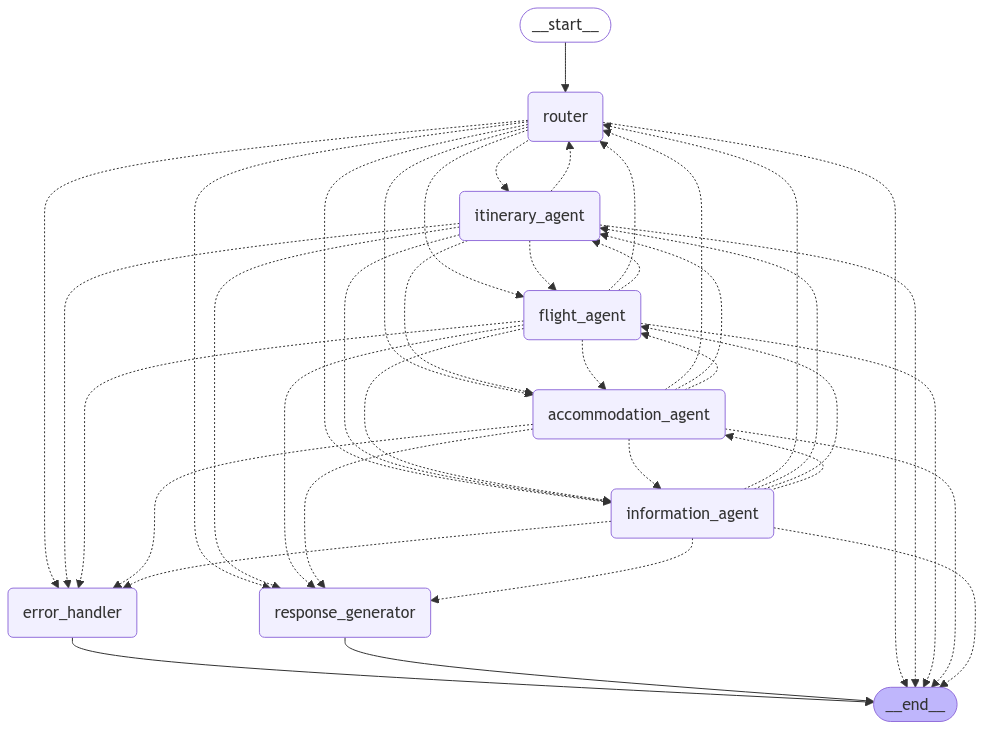

In [15]:
## Step 4: Using the Travel Assistant
# Create the travel assistant
travel_assistant = create_travel_assistant_graph()

In [ ]:
# def save_travel_assistant(travel_assistant, filename='travel_assistant.pkl'):
#     # Ensure directory exists
#     os.makedirs('saved_models', exist_ok=True)
#     filepath = os.path.join('saved_models', filename)
    
#     # Create a dictionary with both the object and the creation function
#     save_data = {
#         'travel_assistant': travel_assistant,
#         'create_graph_function': create_travel_assistant_graph
#     }
    
#     # Save using dill
#     with open(filepath, 'wb') as f:
#         dill.dump(save_data, f)
    
#     print(f"Travel assistant saved to {filepath}")

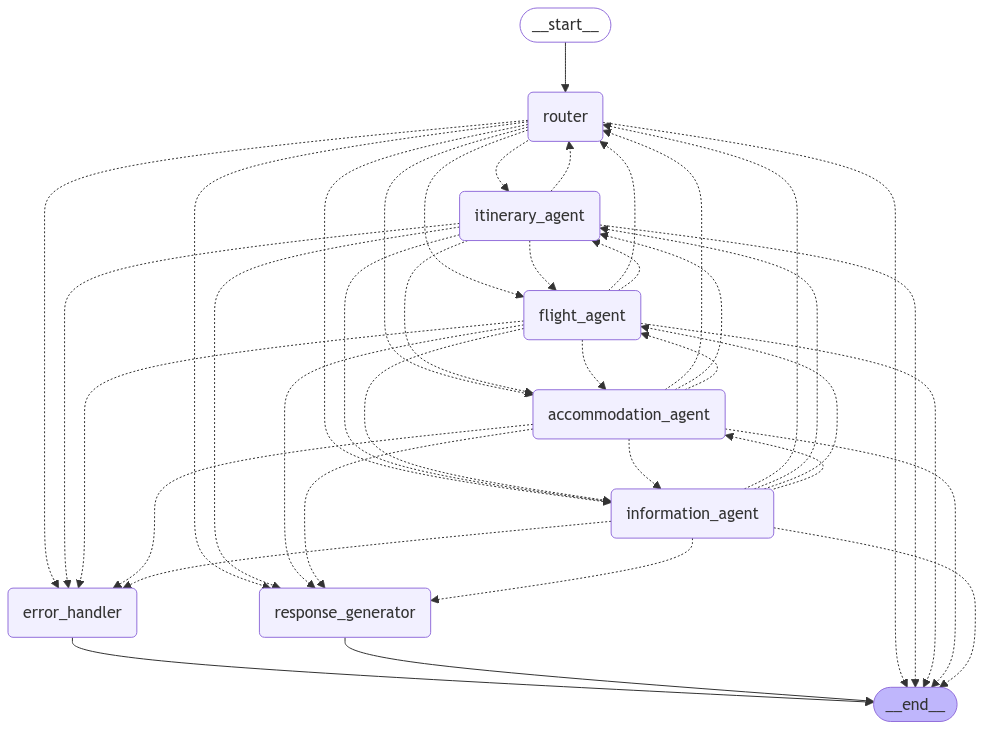

Travel assistant saved to saved_models\travel_assistant.pkl


C:\Users\dabra\AppData\Roaming\Python\Python313\site-packages\dill\_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.AgentState'>.
  StockPickler.save(self, obj, save_persistent_id)
C:\Users\dabra\AppData\Roaming\Python\Python313\site-packages\dill\_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.AgentState'>: __main__.AgentState has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


In [22]:
# # Create and save the travel assistant
# travel_assistant = create_travel_assistant_graph()
# save_travel_assistant(travel_assistant)

In [ ]:
# # Testing the itinerary_agent

# result11 = travel_assistant.invoke({"query": "Plan a 5-day trip to Tokyo in March"})
# print(result11)

# result12 = travel_assistant.invoke({"query": "Can you draft a 3-day trip to California in August?"})
# print(result12)

# result13 = travel_assistant.invoke({"query": "Please make a 5-day budget friendly itinerary for a couple with 2 kids to Austria in December."})
# print(result13)

# result14 = travel_assistant.invoke({"query": "Can you create a 6-day travel plan covering top 5 European castles for a solo traveller in October?"})
# print(result14)

# result15 = travel_assistant.invoke({"query": "Plan a 2-day trip to Miami for two couples in their thirties travelling together."})
# print(result15)

In [ ]:
# # Testing the flight_agent

# result21 = travel_assistant.invoke({"query": "Can you help me find budget flights from Chicago to Miami around March 21, 2025?"})
# print(result21)

# result22 = travel_assistant.invoke({"query": "Can you share three flight options from San Francisco to New York on February 26, 2025?"})
# print(result22)

# result23 = travel_assistant.invoke({"query": "What are the three cheapest flight options available for 1 traveller from San Francisco to Alaska in April 2025?"})
# print(result23)

# result24 = travel_assistant.invoke({"query": "Are there any direct flights from Seatlle to New Delhi in the second week of May?"})
# print(result24)

# result25 = travel_assistant.invoke({"query": "What is the cheapest, direct flight from New York to London in December 2025?"})
# print(result25)

In [ ]:
# # Testing the accommodation_agent

# result31 = travel_assistant.invoke({"query": "Please find 3 hotel recommendations in Paris for 2 guests from May 2 to May 10, 2025 in a price range of $100 to $200 per night."})
# print(result31)

# result32 = travel_assistant.invoke({"query": "Can you help find hotels in New York City for the last weeks of April 2025 for a single person in a nightly budget range of $400 to $600?"})
# print(result32)

# result33 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result33)

# result34 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result34)

# result35 = travel_assistant.invoke({"query": "Can you help me find hotels in Paris near the Eiffel Tower, for the dates May 2 to May 10, 2025, accommodating 2 guests, with a price range of $100 to $200 per night?"})
# print(result35)

In [ ]:
# # Testing the information_agent
# result41 = travel_assistant.invoke({"query": "What's the weather like in Rome in July?"})
# print(result41)

# result42 = travel_assistant.invoke({"query": "What's your travel advice for Amsterdam and London in July?"})
# print(result42)

# result43 = travel_assistant.invoke({"query": "Is there any specific travel advisory for Bali in Indonesia in October 2025?"})
# print(result43)

# result44 = travel_assistant.invoke({"query": "What safety advice do you have for foreigners need to be safe in tourst attractions in Paris?"})
# print(result44)

# result45 = travel_assistant.invoke({"query": "Is India safe for travel for foreign tourists particularly solo women travellers?"})
# print(result45)